In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import urllib.parse
import urllib.request
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import numpy as np

In [2]:
#%pip install scikit-mol
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scikit_mol.fingerprints import MorganFingerprintTransformer
from scikit_mol.conversions import SmilesToMolTransformer

In [3]:
#%pip install mol-ga
import joblib
from mol_ga import mol_libraries, default_ga

In [4]:
def load_csv_from_url(url, filename=None):
    if filename is None:
        filename = os.path.basename(urllib.parse.urlsplit(url).path)
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url, filename)
     
    df = pd.read_csv(filename)
    return df
url = "https://raw.githubusercontent.com/ml-jku/mgenerators-failure-modes/master/assays/processed/CHEMBL3888429.csv"
df = load_csv_from_url(url)
df.head()

,smiles,value,label
0,NC(=O)c1cn(nc1Nc2ccnc(F)c2)C3(CC#N)CCN(Cc4cccn...,6.84,0
1,CN(C1CCC(CC#N)(CC1)n2cc(C(=O)N)c(Nc3ccnc(F)c3)...,6.98,0
2,NC(=O)c1cn(nc1Nc2ccc(F)cc2)C3(CC#N)CCN(CC3)C(=...,7.48,0
3,NC(=O)c1cn(nc1Nc2ccnc(F)c2)C3(CC#N)CCN(CC3)C(=...,8.05,1
4,NC(=O)c1cn(nc1Nc2ccnc(F)c2)C3(CC#N)CCC(CC3)NCc...,8.70,1


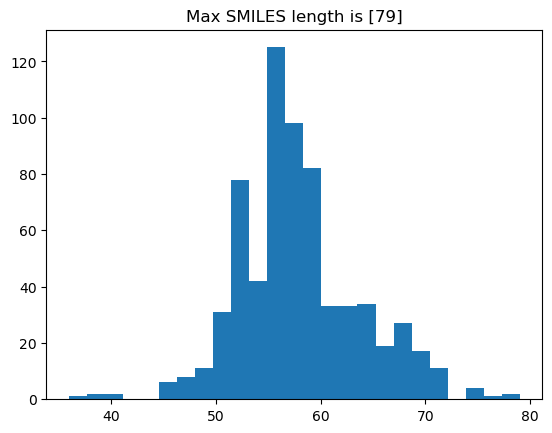

In [5]:
length_smiles = df.smiles.apply(len)
_ = plt.hist(length_smiles, bins=25)
_ = plt.title(f"Max SMILES length is [{max(length_smiles)}]")

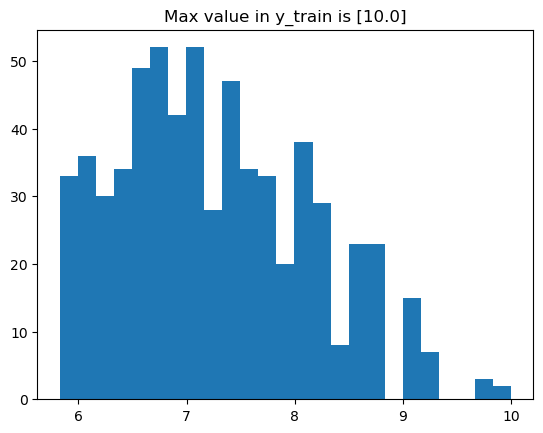

In [6]:
_ = plt.hist(df.value, bins=25)
_ = plt.title(f"Max value in y_train is [{max(df.value)}]")

In [7]:
	
df = df[~df.value.isna()]

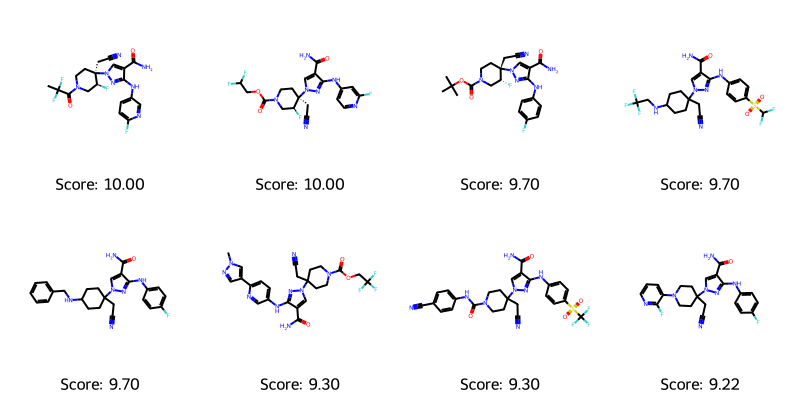

In [8]:
#We feed in tuples of scores, smiles as this makes it easier for the output from the genetic algorithm further down....
def visualize_molecules_with_scores(molecule_data):
    mols = [Chem.MolFromSmiles(smiles) for _, smiles in molecule_data]
    img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=[f'Score: {score:.2f}' for score, _ in molecule_data])
    return img

#Identify the top 8 and create the list of (scores, smiles); actually, value; 
top_indices = np.argsort(df.value)[::-1][:8]
top_molecules_and_scores = list(zip(df.value.values[top_indices],df.smiles.values[top_indices]))
visualize_molecules_with_scores(top_molecules_and_scores) # Pandas could probably give me the top 8 if I googled it


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.smiles, df.value, test_size=0.2, random_state=42) #Good ol'e train_test_split
# Define the Feature Transformer 
morgantrf = MorganFingerprintTransformer()
smilestrf = SmilesToMolTransformer()
feature_pipeline = Pipeline([
    ('smiles2mol', smilestrf),
    ('morgan', morgantrf)
])
X_train_transformed = feature_pipeline.transform(X_train)
X_test_transformed = feature_pipeline.transform(X_test)
print(f"X_train_transformed shape is {X_train_transformed.shape}")

X_train_transformed shape is (510, 2048)


In [10]:
ridge_model = Ridge()
alpha_space = [0.1,10000]
param_grid = {'alpha': np.logspace(np.log10(alpha_space[0]), np.log10(alpha_space[1]), num=50)}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3, return_train_score=True)
grid_search.fit(X_train_transformed, y_train) # CV is used to tune, NEVER the external test-set!!!
print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Average NegRMSE on Training Set: {np.mean(grid_search.cv_results_['mean_train_score'])}")
print(f"Average NegRMSE on Cross-Validation Set: {np.mean(grid_search.cv_results_['mean_test_score'])}")

Best Alpha: 10.985411419875584
Average NegRMSE on Training Set: -0.5993705568456517
Average NegRMSE on Cross-Validation Set: -0.7895764660492643


In [11]:
model = grid_search.best_estimator_
print("Train score:", model.score(X_train_transformed, y_train))
print("Test Score:", model.score(X_test_transformed, y_test))

Train score: 0.6410330315855475
Test Score: 0.3533566781607197


In [12]:
integrated_model = Pipeline((("Featurizer",feature_pipeline),("RidgeRegressor",model)))
integrated_model

Pipeline(steps=(('Featurizer',
                 Pipeline(steps=[('smiles2mol', SmilesToMolTransformer()),
                                 ('morgan', MorganFingerprintTransformer())])),
                ('RidgeRegressor', Ridge(alpha=10.985411419875584))))

In [13]:
	# test
integrated_model.predict(["c1ccccc1", "CO"])

array([5.64209907, 5.49391141])

In [14]:

start_smiles = mol_libraries.random_zinc(1000)
with joblib.Parallel(n_jobs=-1) as parallel:
        ga_results = default_ga(
            starting_population_smiles=start_smiles,
            scoring_function=integrated_model.predict, #How nice it is that the model can read lists of SMILES :-)
            max_generations=7, 
            offspring_size=100,
            parallel=parallel,
            population_size=200, #Should efficiently make it more batch looking, but probably also more prone to mode-collapse
        )


<module 'matplotlib.pyplot' from '/home/alex/anaconda3/envs/allroundclone/lib/python3.8/site-packages/matplotlib/pyplot.py'>

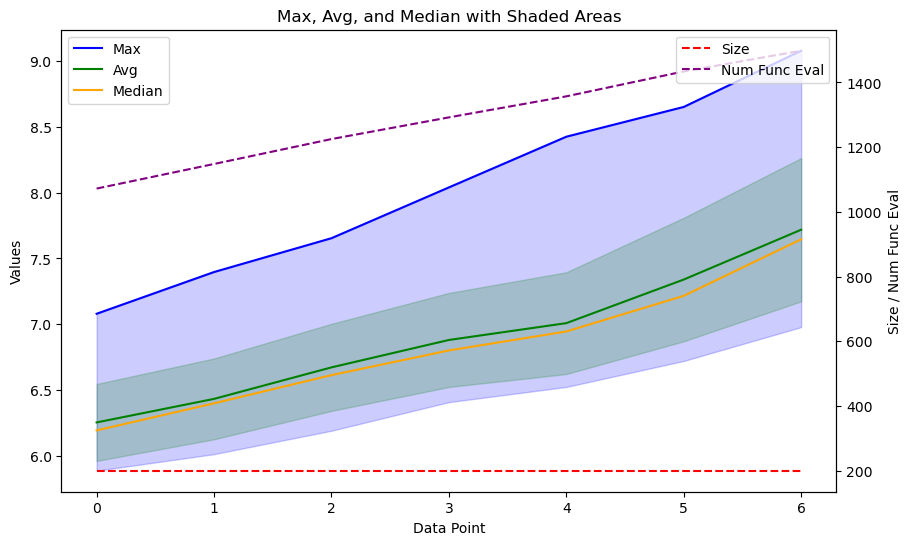

In [15]:
def plot_ga(data):
    max_values = [entry['max'] for entry in data]
    avg_values = [entry['avg'] for entry in data]
    median_values = [entry['median'] for entry in data]
    min_values = [entry['min'] for entry in data]
    std_values = [entry['std'] for entry in data]
    size_values = [entry['size'] for entry in data]
    num_func_eval_values = [entry['num_func_eval'] for entry in data]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(max_values, label='Max', color='blue')
    ax1.plot(avg_values, label='Avg', color='green')
    ax1.plot(median_values, label='Median', color='orange')
    ax1.fill_between(range(len(data)), min_values, max_values, color='blue', alpha=0.2)
    ax1.fill_between(range(len(data)), np.subtract(avg_values, std_values), np.add(avg_values, std_values), color='green', alpha=0.2)
    ax1.set_xlabel('Data Point')
    ax1.set_ylabel('Values')
    ax1.set_title('Max, Avg, and Median with Shaded Areas')
    ax2 = ax1.twinx()
    ax2.plot(size_values, label='Size', linestyle='--', color='red')
    ax2.plot(num_func_eval_values, label='Num Func Eval', linestyle='--', color='purple')
    ax2.set_ylabel('Size / Num Func Eval')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    return plt
plot_ga(ga_results.gen_info)

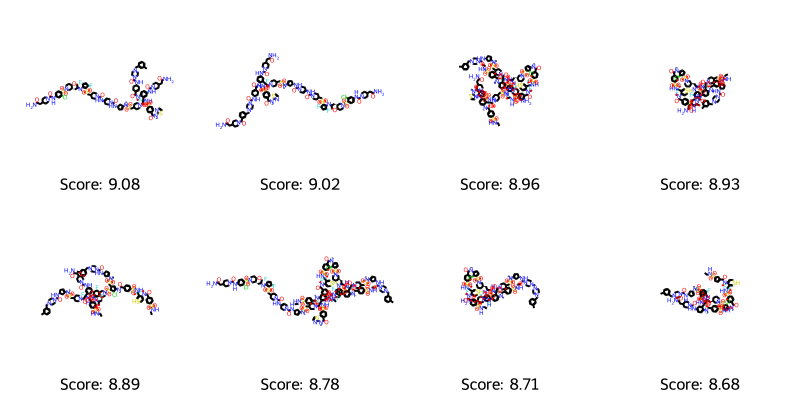

In [16]:
def get_top_ten_tuples(input_list, k=8):
    numbers = np.array([float(item[0]) for item in input_list])
    top_indices = np.argsort(numbers)[::-1][:k]
    top_ten_tuples = [input_list[i] for i in top_indices]
    return top_ten_tuples
best_mols = get_top_ten_tuples(ga_results.population)
visualize_molecules_with_scores(best_mols)

In [17]:
def length_restricted_scoring(smiles_list):
    smiles_lengths = np.array([len(smiles) for smiles in smiles_list])
    scores = integrated_model.predict(smiles_list)
    final_scores = (smiles_lengths < 80) * scores #Largest from dataset was 74
    return list(final_scores)

In [18]:
with joblib.Parallel(n_jobs=-1) as parallel:
    ga_results = default_ga(
        starting_population_smiles=start_smiles,
        scoring_function=length_restricted_scoring,
        max_generations=500,
        offspring_size=100,
        parallel=parallel,
        population_size=5000,
    )

<module 'matplotlib.pyplot' from '/home/alex/anaconda3/envs/allroundclone/lib/python3.8/site-packages/matplotlib/pyplot.py'>

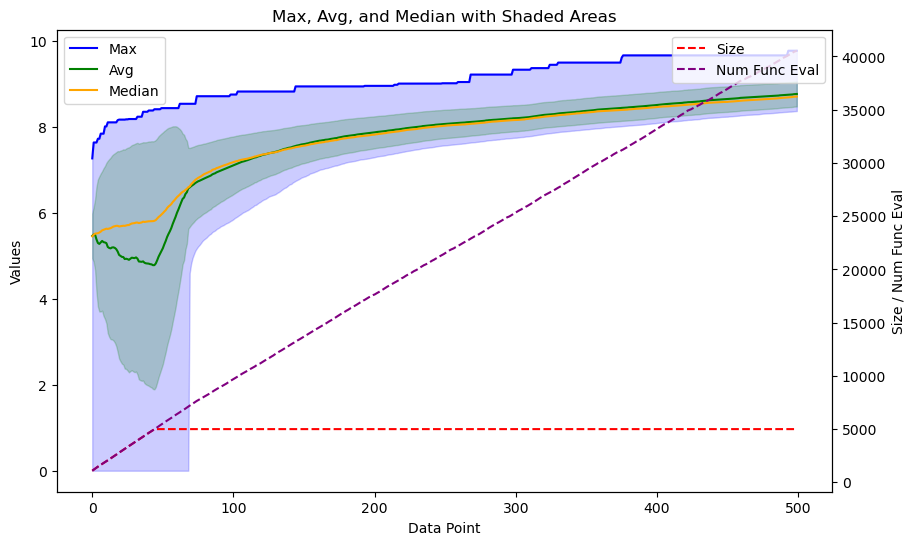

In [19]:
	
plot_ga(ga_results.gen_info)

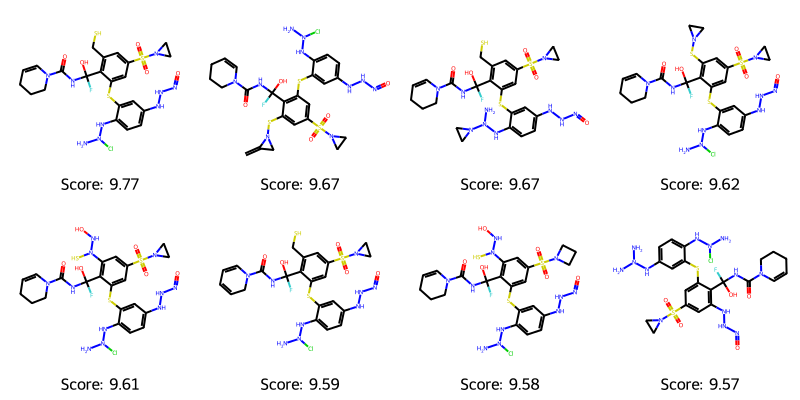

In [20]:
best_mols = get_top_ten_tuples(ga_results.population)
visualize_molecules_with_scores(best_mols)